In [ ]:
# Install necessary libraries
!pip install transformers torch matplotlib seaborn nltk


In [ ]:
!pip uninstall torch -y

Found existing installation: torch 2.4.0
Uninstalling torch-2.4.0:
  Successfully uninstalled torch-2.4.0


In [ ]:
!pip install torch torchvision torchaudio


  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl (797.2 MB)


In [ ]:
!pip install transformers

In [ ]:
import torch
print(f'PyTorch version: {torch.__version__}')

from transformers import pipeline
print("Transformers library is working!")

PyTorch version: 2.4.1+cu121
Transformers library is working!


In [ ]:
# Import libraries
from transformers import pipeline
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Upload your script
import pandas as pd

# List of movie titles and corresponding filenames for the scripts
movies = [
    {'title': 'Jungle Book', 'filename': 'Jungle Book.txt'},
    {'title': 'Peter Pan', 'filename': 'Peter Pan.txt'},
    {'title': 'Dumbo', 'filename': 'Dumbo.txt'},
    {'title': 'Aladdin', 'filename': 'Aladdin.txt'},
    {'title': 'Pocahontas', 'filename': 'Pocahontas.txt'},
    {'title': 'Mulan', 'filename': 'Mulan.txt'},
    {'title': 'Princess and the Frog', 'filename': 'Princess and the Frog.txt'},
    {'title': 'Moana', 'filename': 'Moana.txt'},
    {'title': 'Zootopia', 'filename': 'Zootopia.txt'},
    {'title': 'Elemental', 'filename': 'Elemental.txt'}
]

In [ ]:
# Function to read script from a file with error handling for different encodings
def read_script(filename):
    try:
        # Try reading the file with utf-8 encoding
        with open(filename, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        # If utf-8 fails, try a more forgiving encoding like ISO-8859-1 or Windows-1252
        with open(filename, 'r', encoding='ISO-8859-1') as file:
            return file.read()

In [ ]:
# Initialize the zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Define the diversity labels
racialdiversity_labels = ["Border Transgression", "Empathetic understanding of the Other", "Awaken cultural/ intercultural awareness"]

In [ ]:
# Function to chunk text into manageable size for classification
def chunk_text(sentences, max_length=512):
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        current_length += len(sentence)
        current_chunk.append(sentence)
        # If chunk length exceeds max_length, append it and reset
        if current_length >= max_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_length = 0

            # Add the last chunk if there's remaining text
    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

In [ ]:
# Function to classify the script and aggregate scores for each label
def classify_script(script, labels):  # Add 'labels' as a second argument
    # Tokenize the script into sentences
    sentences = sent_tokenize(script)

    # Split the script into chunks for classification (BERT-like models usually limit to 512 tokens)
    chunks = chunk_text(sentences, max_length=512)

    # Initialize cumulative scores for each label
    cumulative_scores = {label: 0 for label in labels}

    # Calculate the total number of chunks
    total_chunks = len(chunks)

    # Classify each chunk and accumulate the scores
    for chunk in chunks:
        result = classifier(chunk, candidate_labels=labels)
        for i, label in enumerate(result['labels']):
            cumulative_scores[label] += result['scores'][i]

    # Average the scores across chunks
    if total_chunks > 0:  # To avoid division by zero
        avg_scores = {label: cumulative_scores[label] / total_chunks for label in labels}
    else:
        avg_scores = {label: 0 for label in labels}  # Handle edge case for empty scripts

    return avg_scores  # Return the aggregated average scores


In [ ]:
# Initialize an empty DataFrame to store results
df_results = pd.DataFrame(columns=['title', 'racial_diversity'])

In [ ]:
# Initialize an empty DataFrame to store results
df_results = pd.DataFrame(columns=['title', 'racial_diversity'])

# Loop through each movie
for movie in movies:
    title = movie['title']
    filename = movie['filename']

    # Read the script from the file
    script = read_script(filename)

    # Get the confidence scores from the analysis
    scores = classify_script(script, racialdiversity_labels)  # Pass feminism_labels as an argument

    # Create a string representation of feminism for the current movie
    racialdiversity_str = ', '.join([f"{label}: {scores[label]:.2f}" for label in racialdiversity_labels])

    # Create a DataFrame with the current movie's results
    new_row = pd.DataFrame({
        'title': [title],
        'racial_diversity': [racialdiversity_str]
    })

    # Concatenate the new row with the existing dataframe
    df_results = pd.concat([df_results, new_row], ignore_index=True)

# Display the dataframe with classification scores for all movies
print(df_results)

                   title                                   racial_diversity
0            Jungle Book  Border Transgression: 0.15, Empathetic underst...
1              Peter Pan  Border Transgression: 0.14, Empathetic underst...
2                  Dumbo  Border Transgression: 0.14, Empathetic underst...
3                Aladdin  Border Transgression: 0.14, Empathetic underst...
4             Pocahontas  Border Transgression: 0.14, Empathetic underst...
5                  Mulan  Border Transgression: 0.17, Empathetic underst...
6  Princess and the Frog  Border Transgression: 0.15, Empathetic underst...
7                  Moana  Border Transgression: 0.13, Empathetic underst...
8               Zootopia  Border Transgression: 0.13, Empathetic underst...
9              Elemental  Border Transgression: 0.13, Empathetic underst...


<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


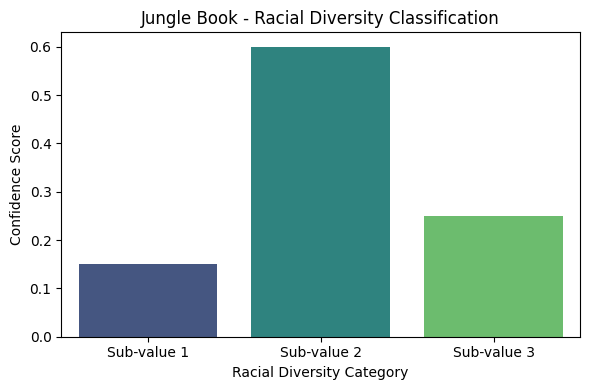

<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


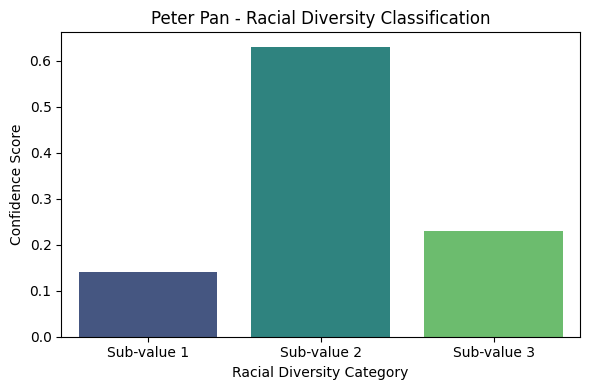

<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


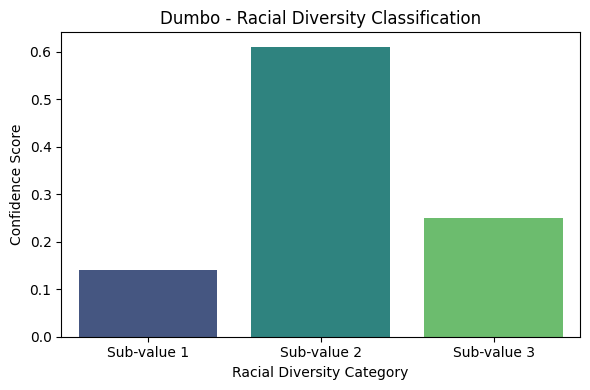

<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


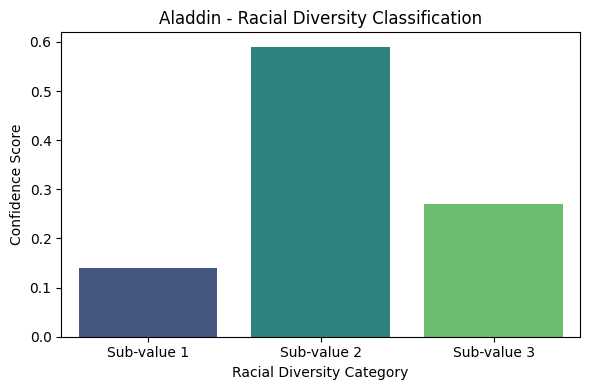

<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


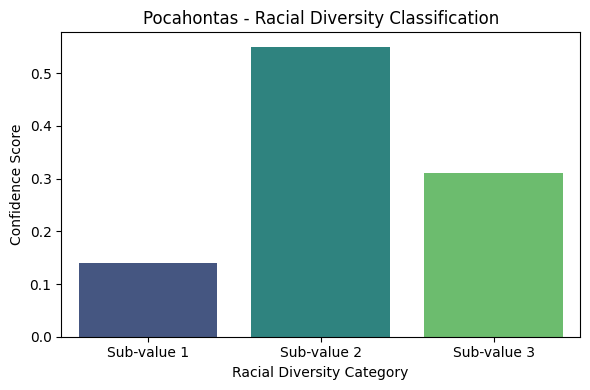

<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


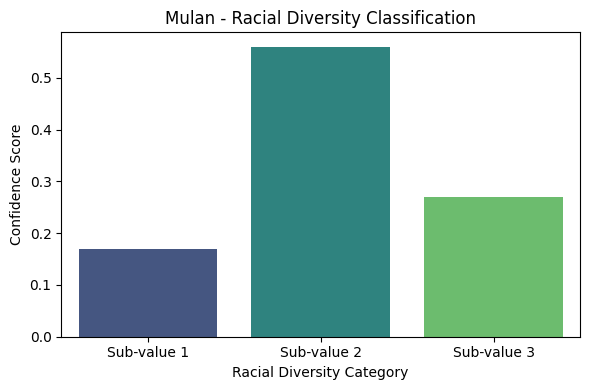

<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


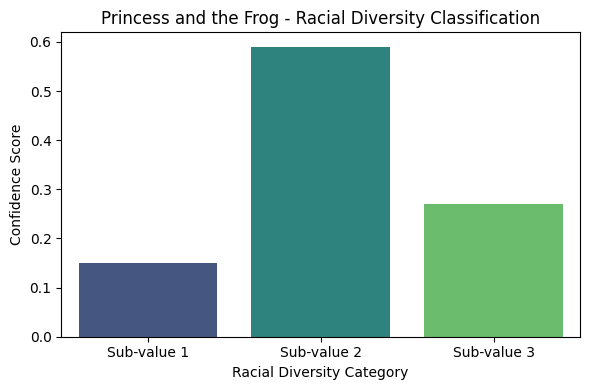

<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


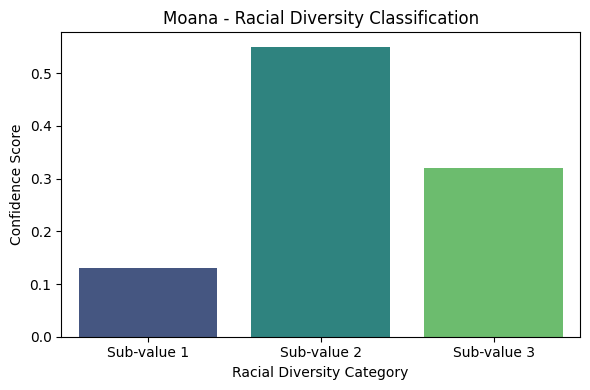

<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


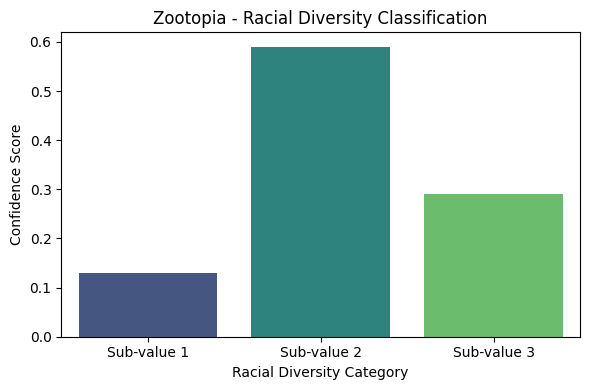

<ipython-input-13-0cc14820a87a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


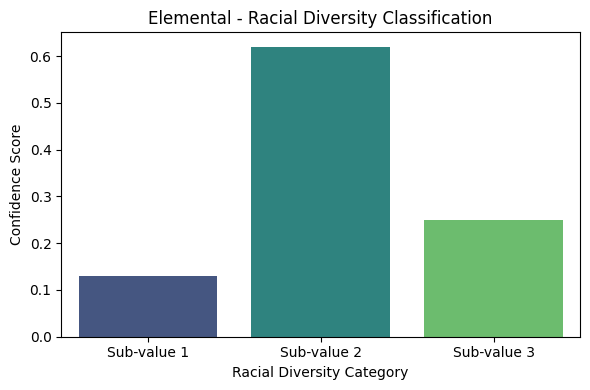

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Split the 'racial_diversity' column into separate columns
df_split = df_results['racial_diversity'].str.extract(r'Border Transgression: (\d+\.\d+), Empathetic understanding of the Other: (\d+\.\d+), Awaken cultural/ intercultural awareness: (\d+\.\d+)')
df_split.columns = ['Border Transgression', 'Empathetic understanding of the Other', 'Awaken cultural/ intercultural awareness']

# Convert the columns to numeric types (float) to allow plotting
df_split = df_split.astype(float)

# Merge the split columns back to the original dataframe
df_results = pd.concat([df_results, df_split], axis=1)

# Step 2: Visualization of classification scores for each movie
def visualize_classification_results_for_all_movies(df_results):
    # Loop through the dataframe (each row represents a movie)
    for i, row in df_results.iterrows():
        # Extract the movie title and classification scores
        movie_title = row['title']
        scores = [row['Border Transgression'], row['Empathetic understanding of the Other'], row['Awaken cultural/ intercultural awareness']]

        # Modify the labels for the x-axis
        labels = ['Sub-value 1', 'Sub-value 2', 'Sub-value 3']

        # Create a barplot for each movie
        plt.figure(figsize=(6, 4))
        sns.barplot(x=labels, y=scores, palette='viridis')

        # Set titles and labels
        plt.title(f'{movie_title} - Racial Diversity Classification')
        plt.xlabel('Racial Diversity Category')
        plt.ylabel('Confidence Score')

        # Show the plot
        plt.tight_layout()
        plt.show()

# Call the function to visualize
visualize_classification_results_for_all_movies(df_results)


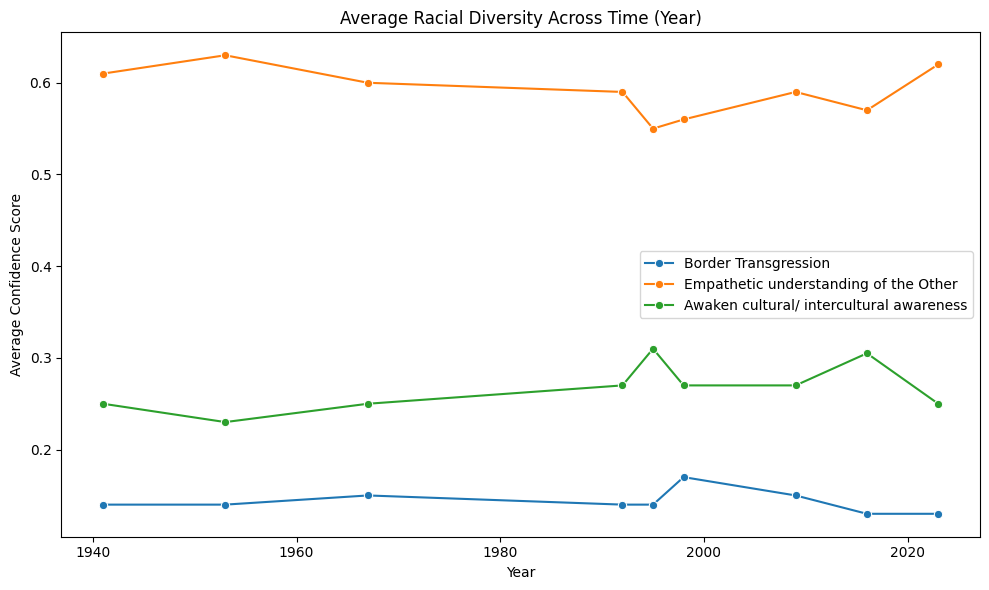

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a DataFrame mapping movies to periods and years (example with extracted years)
movies_periods_years = {
    'Jungle Book': {'period': 'Classics', 'year': 1967},
    'Dumbo': {'period': 'Classics', 'year': 1941},
    'Peter Pan': {'period': 'Classics', 'year': 1953},
    'Aladdin': {'period': 'Renaissance', 'year': 1992},
    'Princess and the Frog': {'period': 'Renaissance', 'year': 2009},
    'Pocahontas': {'period': 'Renaissance', 'year': 1995},
    'Mulan': {'period': 'Renaissance', 'year': 1998},
    'Moana': {'period': 'New Age', 'year': 2016},
    'Zootopia': {'period': 'New Age', 'year': 2016},
    'Elemental': {'period': 'New Age', 'year': 2023},
}

# Step 2: Create the dataframe
df_movies_periods = pd.DataFrame(movies_periods_years).T

# Map the period and year information to the df_results DataFrame
df_results['period'] = df_results['title'].map(df_movies_periods['period'])
df_results['year'] = df_results['title'].map(df_movies_periods['year'])

# Step 3: Aggregate feminism by year
df_aggregate_by_year = df_results.groupby('year')[['Border Transgression', 'Empathetic understanding of the Other', 'Awaken cultural/ intercultural awareness']].mean().reset_index()

# Step 4: Visualization of feminism values across time (year)
def visualize_diversity_across_time(df_aggregate_by_year):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the feminism values across years
    sns.lineplot(data=df_aggregate_by_year, x='year', y='Border Transgression', label='Border Transgression', marker='o')
    sns.lineplot(data=df_aggregate_by_year, x='year', y='Empathetic understanding of the Other', label='Empathetic understanding of the Other', marker='o')
    sns.lineplot(data=df_aggregate_by_year, x='year', y='Awaken cultural/ intercultural awareness', label='Awaken cultural/ intercultural awareness', marker='o')

    # Add titles and labels
    plt.title('Average Racial Diversity Across Time (Year)')
    plt.xlabel('Year')
    plt.ylabel('Average Confidence Score')

    # Show the plot
    plt.tight_layout()
    plt.legend()
    plt.show()

# Call the function to visualize
visualize_diversity_across_time(df_aggregate_by_year)


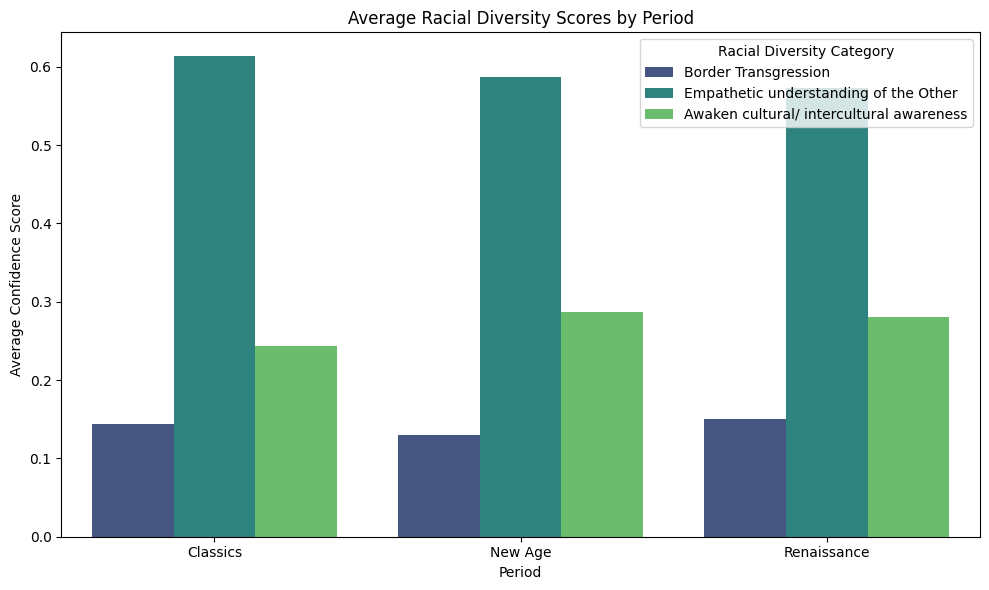

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a DataFrame mapping movies to periods and years (already done)
movies_periods_years = {
 'Jungle Book': {'period': 'Classics', 'year': 1967},
    'Dumbo': {'period': 'Classics', 'year': 1941},
    'Peter Pan': {'period': 'Classics', 'year': 1953},
    'Aladdin': {'period': 'Renaissance', 'year': 1992},
    'Princess and the Frog': {'period': 'Renaissance', 'year': 2009},
    'Pocahontas': {'period': 'Renaissance', 'year': 1995},
    'Mulan': {'period': 'Renaissance', 'year': 1998},
    'Moana': {'period': 'New Age', 'year': 2016},
    'Zootopia': {'period': 'New Age', 'year': 2016},
    'Elemental': {'period': 'New Age', 'year': 2023},
}

# Step 2: Create the dataframe
df_movies_periods = pd.DataFrame(movies_periods_years).T

# Map the period and year information to the df_results DataFrame
df_results['period'] = df_results['title'].map(df_movies_periods['period'])
df_results['year'] = df_results['title'].map(df_movies_periods['year'])

# Step 3: Aggregate racial diversity confidence scores by period
df_aggregate_by_period = df_results.groupby('period')[['Border Transgression', 'Empathetic understanding of the Other', 'Awaken cultural/ intercultural awareness']].mean().reset_index()

# Step 4: Visualization of aggregate confidence scores by period
def visualize_racial_diversity_by_period(df_aggregate_by_period):
    # Reshape the dataframe for easier plotting
    df_melt = df_aggregate_by_period.melt(id_vars='period', var_name='Racial Diversity Category', value_name='Average Confidence Score')

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Create the barplot
    sns.barplot(data=df_melt, x='period', y='Average Confidence Score', hue='Racial Diversity Category', palette='viridis')

    # Add titles and labels
    plt.title('Average Racial Diversity Scores by Period')
    plt.xlabel('Period')
    plt.ylabel('Average Confidence Score')

    # Show the plot
    plt.tight_layout()
    plt.legend(title='Racial Diversity Category')
    plt.show()

# Call the function to visualize
visualize_racial_diversity_by_period(df_aggregate_by_period)
